# Исследование заказов такси<a class="tocSkip">
<a id="start"></a>

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных--и-предобработка" data-toc-modified-id="Обзор-данных--и-предобработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных  и предобработка</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выявление-сезонности-и-трендов" data-toc-modified-id="Выявление-сезонности-и-трендов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выявление сезонности и трендов</a></span></li><li><span><a href="#Стационарность" data-toc-modified-id="Стационарность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Стационарность</a></span></li><li><span><a href="#Добавление-новых-признаков" data-toc-modified-id="Добавление-новых-признаков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Добавление новых признаков</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Линейная-регрессия-2.0" data-toc-modified-id="Линейная-регрессия-2.0-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия 2.0</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>SARIMA</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Описание проекта

### Записка к данным<a class="tocSkip">

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.
___

Перед началом анализа импортируем необходимые библиотеки и создадим несколько функций.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import seaborn as sns

from scipy import stats as st
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso, Ridge

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = None
%matplotlib inline

In [3]:
colors = ['mediumslateblue', 'darkslateblue']
colors2 = ['cornflowerblue', 'darkslateblue']

In [4]:
def make_split(data):
    test = data.loc[test_index]
    train = data.loc[train_index].dropna()
    x_test = test.drop(columns=['num_orders'])
    y_test = test['num_orders']
    x_train = train.drop(columns=['num_orders'])
    y_train = train['num_orders']
    return x_train, y_train, x_test, y_test

In [5]:
def test_hypothesis(x, stat='adfuller'):
    if stat == 'adfuller':
        p = sm.tsa.stattools.adfuller(x)[1]  
    print('p-value: {:.2g}'.format(p))    
    return

In [6]:
def plot_line(data, xlabel, ylabel, labels=None, title=None, xlim=None, ylim=None,  
              figsize=(15,5), colors=colors, lw=None):
    fig, axes = plt.subplots(figsize=figsize)
    axes.set_facecolor('whitesmoke')
    
    if not lw:
        lw = [3] * len(data)
    for i in range(len(data)):
        axes.plot(data[i], linewidth=lw[i], color=colors[i], label=labels[i])
    axes.legend(facecolor='ghostwhite', title_fontsize=14, shadow=True, fancybox=False, loc='upper left')  
    axes.set_xlabel(xlabel, fontsize=14)
    axes.set_ylabel(ylabel, fontsize=14)   
    if title:
        axes.set_title(title, fontsize=16, pad=20)
    if xlim:
        axes.set_xlim(xlim)
    if ylim:
        axes.set_ylim(ylim)
    axes.grid(color='w', lw=1, axis='y')
    axes.yaxis.set_ticks_position('none')
    plt.show()

In [7]:
def plot_autocorr(data, label, lags=None, figsize=(15,5), title=True, kind='acf'):
    colors = ['mediumslateblue', 'royalblue']
    fig, axes = plt.subplots(figsize=figsize)
    axes.set_facecolor('whitesmoke')
    if lags:
        if kind == 'acf':
            sm.graphics.tsa.plot_acf(data, lags=lags, ax=axes, color=colors[1], zero=False)
        elif kind == 'pacf':
            sm.graphics.tsa.plot_pacf(data, lags=lags, ax=axes, color=colors[1], zero=False)
    else:
        if kind == 'acf':
            sm.graphics.tsa.plot_acf(data, ax=axes, color=colors[0])
        elif kind == 'pacf':
            sm.graphics.tsa.plot_pacf(data, ax=axes, color=colors[0])
    for item in axes.collections:
        if type(item) == PolyCollection:
            item.set_facecolor(colors[0])
    axes.set_xlabel('Лаг, {}'.format(label), fontsize=14)
    axes.set_ylabel('Автокорреляция', fontsize=14)
    if title == True:
        axes.set_title('Коррелограмма', fontsize=16, pad=20)
    elif title:
        axes.set_title(title, fontsize=16, pad=20)
    axes.grid(color='w', lw=1, axis='both')
    axes.yaxis.set_ticks_position('none')
    axes.set_axisbelow(True)
    plt.show()

In [8]:
def plot_corr_matrix(data, mask=False, figsize=(15,15)):
    size = len(data)
    if mask: 
        mask = np.triu(np.ones((size, size)), k=1)
    else: 
        mask = np.zeros((size, size))    
    fig, axes = plt.subplots(figsize=figsize)
    axes = sns.heatmap(data, annot=True, fmt='.2f', mask=mask, square=False)
    axes.set_title('Корреляционная матрица', fontsize=16, pad=20)
    axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
    b, t = plt.ylim() 
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()

# Обзор данных  и предобработка
[к оглавлению](#start)

Откроем файл и изучим общую информацию.

In [9]:
data = pd.read_csv('taxi.csv')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В таблице ~26 тыс. объектов, пропуски отсутствуют. Столбцов два:
* datetime — дата и время
* num_orders — количество заказов такси

Приведём первый столбец к типу `datetime` и установим его в качестве индекса строк.

In [11]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

In [12]:
if data.index.is_monotonic:
    print('Строки упорядочены по времени')

Строки упорядочены по времени


In [13]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В таблице содержится количество заказов такси за каждые 10 минут. Поскольку нам необходимо научиться предсказывать число заказов на следующий час, ресемплируем ряд.

In [14]:
data = data.resample('1H').sum()

### Вывод <a class="tocSkip">
    
Предварительный анализ не выявил проблем с данными.

# Исследовательский анализ данных 
[к оглавлению](#start)

### Деление выборки на обучение и тест <a class="tocSkip">

Сделаем тестовую выборку размером 10% от исходных данных, валидационную — 10% от оставшегося.

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train_index = train.index
test_index = test.index

_, valid = train_test_split(train, shuffle=False, test_size=0.1)
valid_index = valid.index
split_index = [0 if x in valid_index else -1 for x in train_index]
pds = PredefinedSplit(test_fold = split_index)

print('{} объекта в обучении (из них {} в валидации) и {} в тесте'.format(len(train), len(valid), len(test)))

3974 объекта в обучении (из них 398 в валидации) и 442 в тесте


Далее при анализе данных будем рассматривать объекты только из обучающей выборки.

In [16]:
data_ = data.loc[train_index].copy()

## Выявление сезонности и трендов 
[к оглавлению](#start)

Построим график заказов такси.

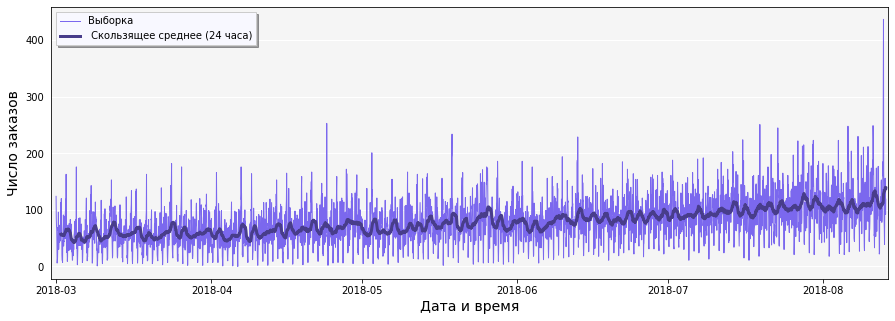

In [17]:
plot_line(
    [data_, data_.rolling(24).mean()], 'Дата и время', 'Число заказов', 
    ['Выборка',' Скользящее среднее (24 часа)'], colors=colors, lw=[1,3], xlim=('2018-02-28','2018-08-14')
)

Ряд нестационарный: отчётливо виден тренд к увеличению среднего числа заказов со временем. Сезонности визуально не наблюдается. Попробуем изменить масштаб.

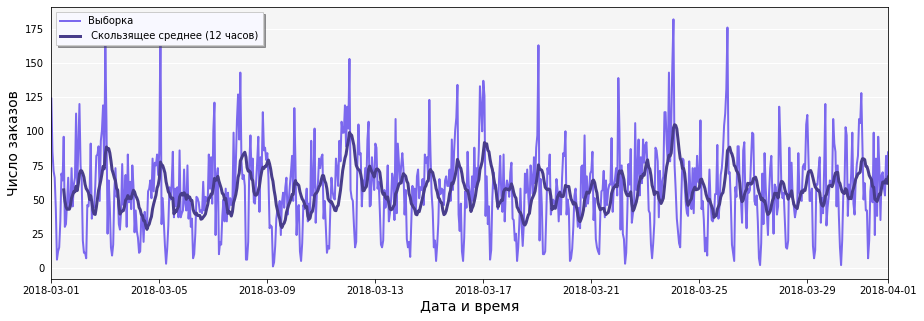

In [18]:
plot_line(
    [data_['2018-03-01':'2018-04-01'], data_['2018-03-01':'2018-04-01'].rolling(12).mean()], 'Дата и время', 
    'Число заказов', ['Выборка',' Скользящее среднее (12 часов)'],
    xlim=('2018-03', '2018-04'), colors=colors, lw=[2,3]
)

В увеличенном масштабе кажется, что ряд периодичен с T=24 часа. Чтобы проверить это, построим коррелограмму.

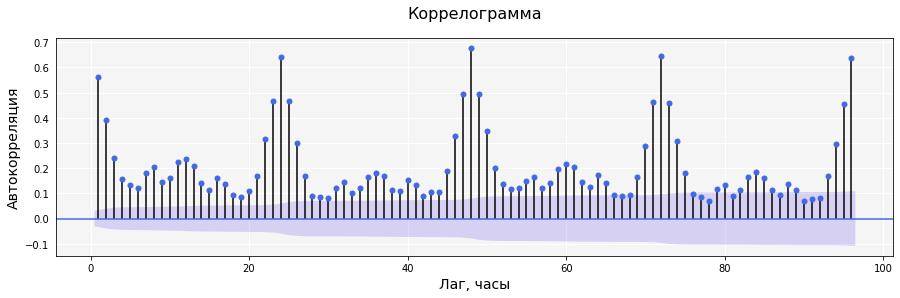

In [19]:
plot_autocorr(data_, 'часы', lags=96, figsize=(15,4))

Действительно, у ряда выраженная сезонность: в лагах, кратных 24 часам, значения автокорреляции максимальны. Все автокорреляции на графике довольно большие — они значимо отличаются от нуля.  Какого-либо тренда не видно. 

Выполним ресемплирование ряда с интервалом в 1 сутки и снова построим коррелограмму.

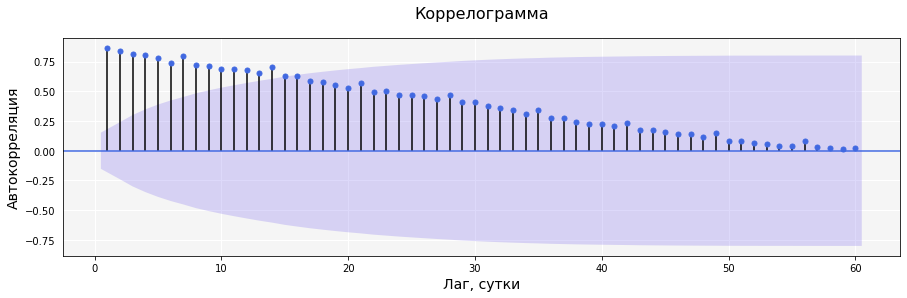

In [20]:
plot_autocorr(data_.resample('1D').sum(), 'сутки', lags=60, figsize=(15,4))

На этой коррелограмме сезонность уже полностью задавлена трендом: с ростом лага автокорреляции монотонно уменьшаются и при лаге >15 суток отличия от нуля становятся статистически незначимыми. При этом, небольшая сезонность тут всё же видна: автокорреляции при лагах 7 и 14 дней немного больше по сравнению с соседними. Месячная сезонность, видимо, отсутствует. Циклы (т.е. изменения ряда с переменным периодом) тоже отсутствуют.

Разложим ряд на 3 компоненты.

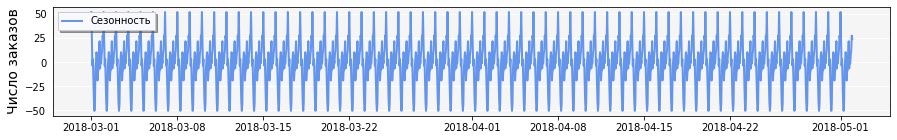

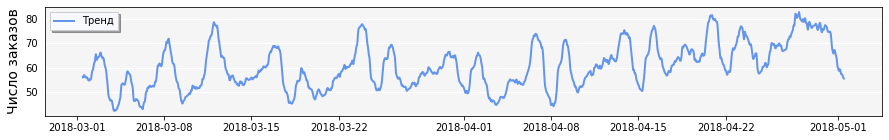

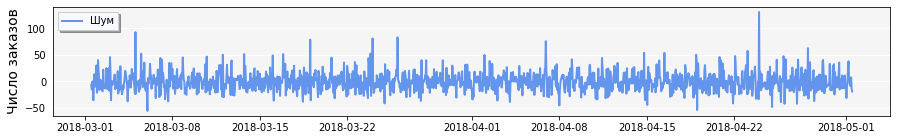

In [21]:
decomposed = seasonal_decompose(data_['2018-03-01':'2018-05-01'])
for c, l in [(decomposed.seasonal, 'Сезонность'), (decomposed.trend, 'Тренд'), (decomposed.resid, 'Шум')]:
    plot_line([c], '', 'Число заказов', labels=[l], figsize=[15,2], colors=colors2, lw=[2])

Разложение произошло, как и ожидалось:
* период сезонной компоненты составляет 24 часа
* шум похож на белый (среднее 0, дисперсия не меняется со временем)
* а вот тренд кажется не монотонной, а периодической функцией с периодом в неделю. Для проверки разложим на компоненты ресемплированный с интервалом в сутки ряд 

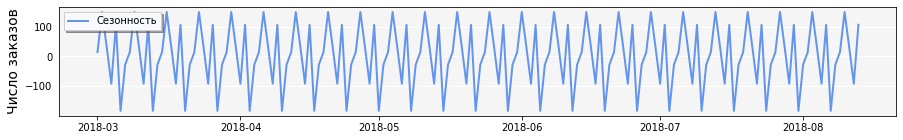

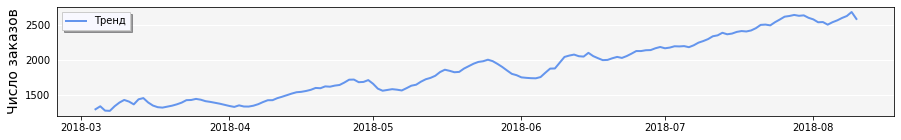

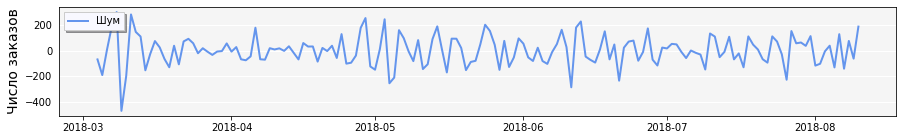

In [22]:
decomposed_2 = seasonal_decompose(data_.resample('1D').sum())
for c, l in [(decomposed_2.seasonal, 'Сезонность'), (decomposed_2.trend, 'Тренд'), (decomposed_2.resid, 'Шум')]:
    plot_line([c], '', 'Число заказов', labels=[l], figsize=[15,2], colors=colors2, lw=[2])

Теперь период сезонной компоненты составляет 1 неделю, а тренд представляет собой монотонно возрастающую функцию. При этом сезонность выражена слабо, т.к. амплитуда её колебаний мала по сравнению с шумом и трендом.

### Вывод <a class="tocSkip">
    
Таким образом, временной ряд содержит 4 компоненты:
1. Сильно выраженная сезонная с периодом 1 сутки
2. Менее выраженная сезонная с периодом 1 неделя
3. Тренд (нелинейно возрастающий)
4. Шум

## Стационарность 
[к оглавлению](#start)

Как уже говорилось ранее, временной ряд нестационарен. Сформулируем гипотезы:
* $H_0:$ временной ряд нестационарен
* $H_1:$ $H_0$ неверна

Проверять будем с помощью критерия Дики — Фуллера. Выберем уровень статистической значимости $\alpha=5\%$.

In [23]:
test_hypothesis(data_['num_orders'], stat='adfuller')

p-value: 0.00073


Гипотеза нестационарности отвергается, однако в данных, очевидно, есть тренд. Попробуем привести ряд к стационарному.

### 1. Стабилизация дисперсии <a class="tocSkip">

Посмотрим, как меняется разброс числа заказов со временем. 

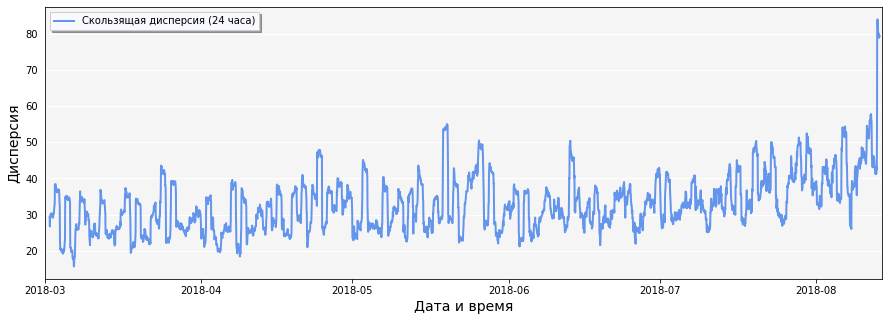

In [24]:
plot_line(
    [data_['num_orders'].rolling(24).std()], 'Дата и время', 'Дисперсия', 
    ['Скользящая дисперсия (24 часа)'], colors=colors2, lw=[2], xlim=('2018-03', '2018-08-14')
)

Из графика видим, что дисперсия ряда не постоянна. Если в марте-апреле 2018 разброс числа заказов в час составлял в среднем 5-6 заказов, то к августу 2018 разброс увеличился до 6-9 заказов. Стабилизируем дисперсию с помощью преобразования Бокса — Кокса:

$$y' = \cases{
ln y, \quad\lambda=0 \\
\frac{y^{\lambda} - 1}{\lambda}, \quad\lambda\neq 0
}$$

In [25]:
st_data = data_.copy()
st_data.columns = ['init']

In [26]:
st_data['st_sigma'], lmbd = st.boxcox(st_data['init'] + 1) # прибавляем 1, т.к. в выборке есть нули
print('lambda = {:.3f}'.format(lmbd))

lambda = 0.605


Сразу создадим функцию для обратного преобразования.

In [27]:
def inv_boxcox(y, lmbd):
    if lmbd == 0:
        return(np.exp(y))
    else:
        return (lmbd * y + 1)**(1 / lmbd) - 1

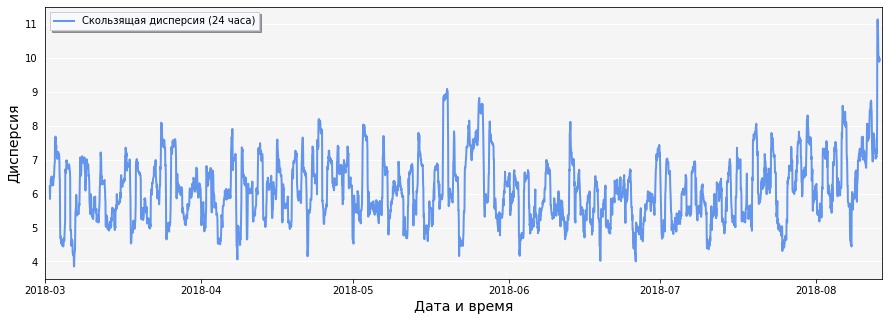

p-value: 0.00059


In [28]:
plot_line(
    [st_data['st_sigma'].rolling(24).std()], 'Дата и время', 'Дисперсия', 
    ['Скользящая дисперсия (24 часа)'], xlim=('2018-03', '2018-08-14'), colors=colors2, lw=[2]
)
test_hypothesis(st_data['st_sigma'].dropna(), stat='adfuller')

После преобразования дисперсия, кажется, всё ещё не постоянна, однако она уже не так сильно меняется со временем. При этом гипотеза нестационарности отвергается немного увереннее :)

### 2. Дифференцирование <a class="tocSkip">

Теперь попробуем сезонное дифференцирование:
$$y''_t = y'_t - y'_{t-s},$$
где $s$ — период сезонной компоненты ряда (в нашем случае $s$ = 24 часа). 

Затем добавим обычное дифференцирование:
$$y'''_t = y''_t - y''_{t-1},$$
и посмотрим, как это повлияет на коррелограммы.

In [29]:
st_data['st_sigma_diff'] = st_data['st_sigma'] - st_data['st_sigma'].shift(24)
st_data['st_sigma_diff2'] = st_data['st_sigma_diff'] - st_data['st_sigma_diff'].shift(1)

Посмотрим на изменения в суточной сезонности.

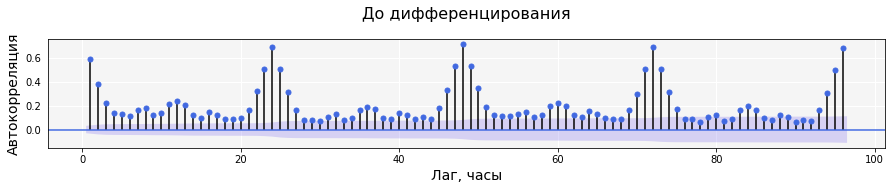

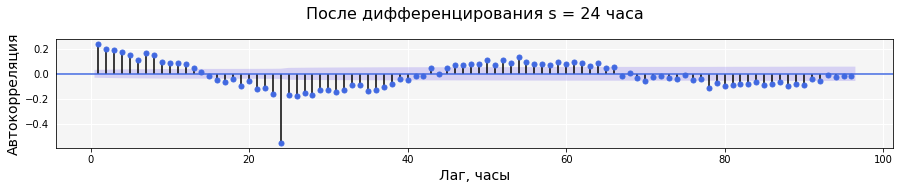

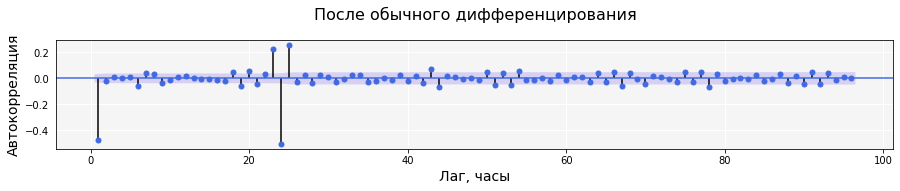

In [30]:
plot_autocorr(st_data['st_sigma'], 'часы', lags=96, figsize=(15,2), title='До дифференцирования')
plot_autocorr(st_data['st_sigma_diff'].dropna(), 'часы', lags=96, figsize=(15,2), 
              title='После дифференцирования s = 24 часа')
plot_autocorr(st_data['st_sigma_diff2'].dropna(), 'часы', lags=96, figsize=(15,2), 
              title='После обычного дифференцирования')

* Видим, что первое дифференцирование, как и ожидалось, позволило избавиться от суточной сезонности. После этого преобразования все автокорреляции, кратные 24 часам, уменьшились. Относительно высокое значение осталось только при первом лаге в 24 часа. 
* Второе дифференцирование ещё уменьшило автокорреляции. В результате статистически значимой осталась только корреляция с лагом 24 часа.

Посмотрим, что происходило с недельной сезонностью.

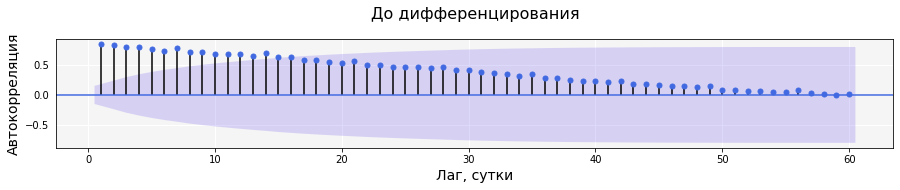

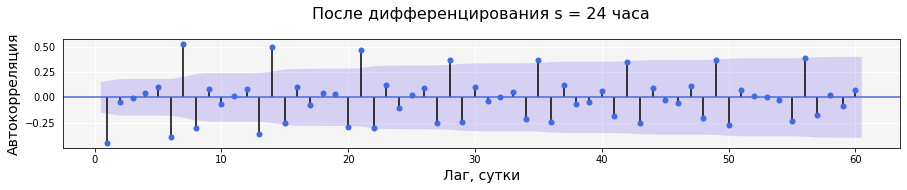

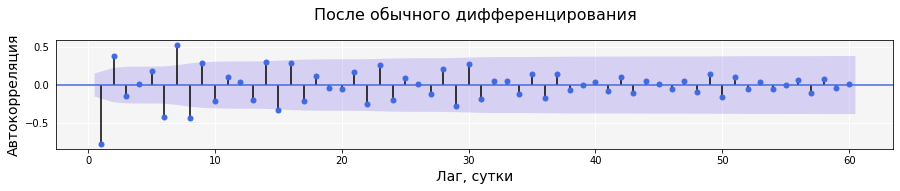

In [31]:
plot_autocorr(st_data['st_sigma'].resample('1D').sum(), 'сутки', lags=60, figsize=(15,2), 
              title='До дифференцирования')
plot_autocorr(st_data['st_sigma_diff'].dropna().resample('1D').sum(), 'сутки', lags=60, figsize=(15,2), 
              title='После дифференцирования s = 24 часа')
plot_autocorr(st_data['st_sigma_diff2'].dropna().resample('1D').sum(), 'сутки', lags=60, figsize=(15,2), 
              title='После обычного дифференцирования')

Здесь всё интереснее :)
* Первое дифференцирование, похоже, не повлияло на недельную сезонность. Однако оно позволило избавиться от тренда: на второй коррелограмме отчётливо видна недельная сезонность в то время, как на первой она была полностью задавлена трендом.
* А вот второе дифференцирование уже избавило от недельной сезонности. В результате статистически значимой осталась только автокорреляция при лаге в 7 суток.

Разложим полученный ряд на 3 составляющие.

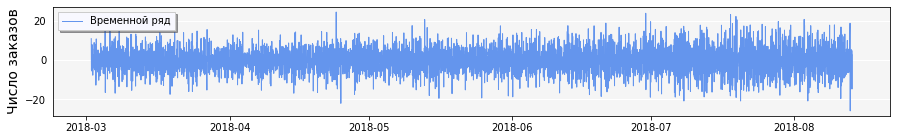

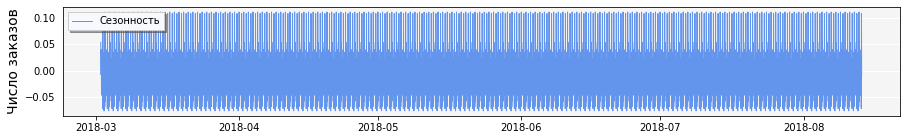

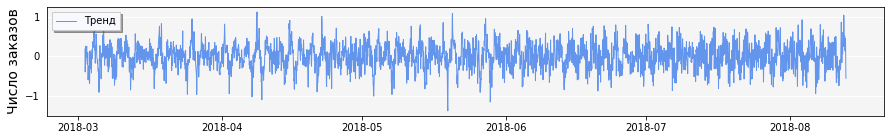

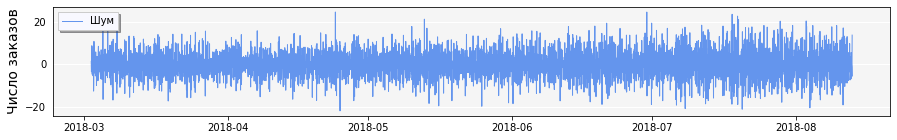

p-value: 0


In [32]:
decomposed = seasonal_decompose(st_data['st_sigma_diff2'].dropna())
plot_line([st_data['st_sigma_diff2'].dropna()], '', 'Число заказов', 
          labels=['Временной ряд'], figsize=[15,2], colors=colors2, lw=[1])
for c, l in [(decomposed.seasonal, 'Сезонность'), (decomposed.trend, 'Тренд'), (decomposed.resid, 'Шум')]:
    plot_line([c], '', 'Число заказов', labels=[l], figsize=[15,2], colors=colors2, lw=[1])
test_hypothesis(st_data['st_sigma_diff2'].dropna(), stat='adfuller')

Похоже, нам удалось избавиться и от сезонной составляющей ряда, и от тренда, поскольку:
* амплитуда этих компонент мала по сравнению с амплитудой шума
* тренд больше не возрастает со временем  

Кроме того, гипотеза нестационарности теперь уверенно отвергается :) 

### Вывод <a class="tocSkip">

Преобразование Бокса — Кокса, сезонное дифференцироваяние с $s$ = 24 часа и обычное дифференцирование привели временной ряд к стационарному.

## Добавление новых признаков 
[к оглавлению](#start)

### Календарные признаки <a class="tocSkip">

Добавим в выборку календарные признаки. В нашем случае это
* количественные: месяц и день года
* циклические категориальные: день недели, день месяца и час. Мы можем либо закодировать их, либо выполнить синусное/косинусное преобразование, т.е. заменить признак $f$ на два количественных: 
$$f \to \cases{ \sin\left(\frac{2\pi}{T} f\right)\\\quad\\\cos\left(\frac{2\pi}{T} f\right)},$$
где $T$ — период.

Для описания тренда ряда также может быть полезен порядковый номер объекта: `n` — номер часа в году, считая от 00:00:00 01:03:2018.

In [33]:
def make_calendar_features(data):
    data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data.index.day / 31)
    data['day_cos'] = np.cos(2 * np.pi * data.index.day / 31)
    data['dayofweek_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['dayofweek_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    data['month'] = data.index.month
    data['dayofyear'] = data.index.dayofyear
    data['n'] = (data.index.dayofyear - data.index.dayofyear[0]) * 24 + data.index.hour # порядковый номер

### Предыдущие значения временного ряда <a class="tocSkip">

Логично добавить ближайшие предыдущие значения ряда, а также значения, отстающие на промежуток времени, кратный сезонному периоду (например, кратный 1 суткам и 1 неделе).

In [34]:
def make_lag_features(data, max_lag, season_lags):  
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    for lag in season_lags:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

### Скользящее среднее <a class="tocSkip">

Скользящее среднее поможет описать тренд временного ряда. 

In [35]:
def make_rolling_features(data, window):  
    data['rolling_mean'] = data['num_orders'].shift().rolling(window).mean()

Объединим эти функции.

In [36]:
def AddFeatures(data, max_lag, season_lags, window):
    X = data.copy()
    make_calendar_features(X)
    make_lag_features(X, max_lag, season_lags)
    make_rolling_features(X, window)
    return X

Вычислим значения новых признаков на тестовой выборке и изучим их корреляцию с таргетом.

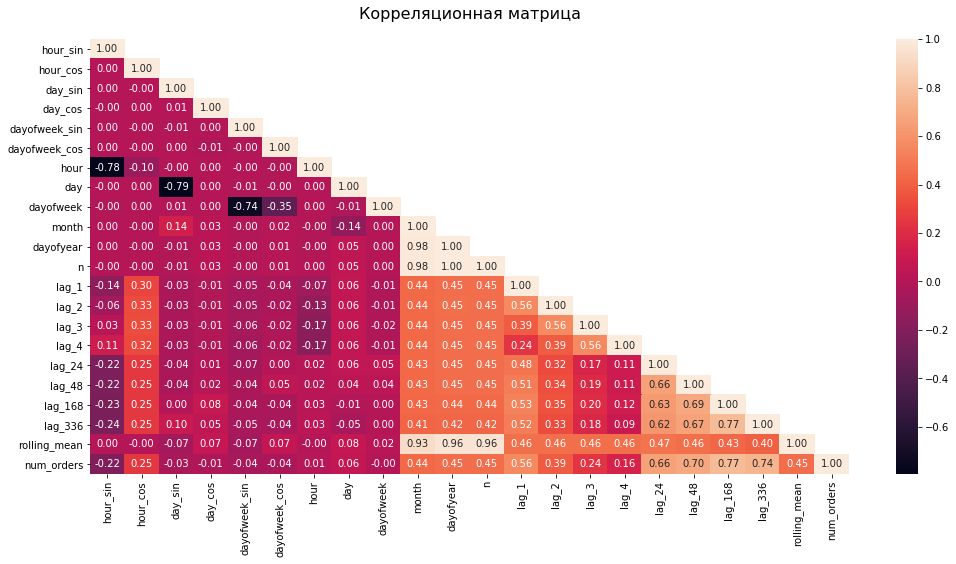

In [37]:
x = AddFeatures(data.loc[train_index], 4, [24, 48, 168, 168*2], 96)
plot_corr_matrix(x[list(x.columns[1:]) + ['num_orders']].corr(), mask=True, figsize=(17,8))

* в выборке есть сильно скоррелированные признаки $\to$ при обучении линейных моделей нужно использовать регуляризацию
* циклические признаки вроде часа и дня недели хуже коррелируют с таргетом, чем их синусы/косинусы
* наиболее сильная корреляция с таргетом наблюдается у отстающих значений с небольшими лагами в несколько часов и сезонными лагами, кратными 24 часам
* максимальная корреляция с таргетом у признаков `lag_168` и `lag_336`. С одной стороны, эти признаки самые информативные, а с другой, добавив их в выборку, мы потеряем данные за 2 недели, что может ухудшить качество модели.

### Вывод <a class="tocSkip">

Большинство созданных признаков напрямую связаны с целевым.

# Обучение модели
[к оглавлению](#start)

Итак, перед нами задача регрессии. Метрика качества RMSE.

### Константная модель <a class="tocSkip">

In [38]:
y_train = data.loc[train_index]
y_test = data.loc[test_index]

In [39]:
prediction_const =  pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
scores = pd.DataFrame({ 
    'RMSE': mean_squared_error(y_test, prediction_const)**0.5,
    'MAE': mean_absolute_error(y_test, prediction_const),
    'R2': r2_score(y_test, prediction_const), 
    'max_error': max_error(y_test, prediction_const),
}, index=['Константная модель'])
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709


In [40]:
pred_previous = y_test.shift(1).fillna(y_train.iloc[-1])
scores.loc['Предыдущее значение ряда'] = [
    mean_squared_error(y_test, pred_previous)**0.5,
    mean_absolute_error(y_test, pred_previous)**0.5,
    r2_score(y_test, pred_previous),
    max_error(y_test, pred_previous)
]
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709
Предыдущее значение ряда,58.856,6.706,-0.011,238.000


Качество довольно хорошее, особенно у второй модели :)  
Интересно, что MAE оказалась намного меньше по сравнению с RMSE. 

### Создание пайплайна <a class="tocSkip">

Пайплайн будет включать предобработку (кодирование, масштабирование и добавление признаков второго порядка и выше) и обучение модели.

In [41]:
cat_columns = ['hour', 'day', 'dayofweek']
poly = PolynomialFeatures(degree=2, include_bias=False)
transformer = ColumnTransformer(remainder='passthrough', transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_columns),
    ('poly', poly, np.arange(-12, -1))
])

pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('scaler', None),
    ('model', Lasso(random_state=42))
])

## Линейная регрессия  
[к оглавлению](#start)

Сначала рассмотрим линейную регрессию. Перед обучением этой модели признаки нужно масштабировать, категориальные признаки закодировать техникой *OHE*. Также имеет смысл добавить признаки второго и более высоких порядков.

Подберём оптимальные гиперпараметры модели:
* тип регуляризации,
* коэффициент регуляризации,

а также способы предобработки:
* тип масштабирования,
* степень `PolynomialFeatures()`,
* максимальный лаг,
* сезонные лаги,
* размер окна скользящего среднего.

Оценивать качество будем на отложенной выборке. Последние три гиперпараметра будем подбирать в цикле, остальные можно засунуть в `GridSearchCV()` :)  

### Подбор гиперпараметров <a class="tocSkip">

``` python
parameters_grid = {
    'transformer__poly__degree': [2], # от 1 до 3
    'scaler': [StandardScaler(), MinMaxScaler()],
    'model': [Lasso(random_state=42), Ridge(random_state=42)],
    'model__alpha': [10**i for i in np.arange(-3, 1, 1.)] # от 10^(-5) до 10^5
}
best_score = -1e10
prep_params = []
best_params = {}

for max_lag in [10]: # от 1 до 12
    for season_lags in [[24, 48], [24, 48, 72, 96, 168]]: # от 24 до 168 с шагом 24
        for window in [36]: # 12, 24, 36, 48
            
            x = AddFeatures(data, max_lag, season_lags, window)
            x_train, y_train, _, _ = make_split(x)
            
            split_index = [0 if x in valid_index else -1 for x in x_train.index]
            pds = PredefinedSplit(test_fold = split_index) 
            
            transformer = ColumnTransformer(remainder='passthrough', transformers=[
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_columns),
                ('poly', poly, [col for col in x_train.columns if col not in cat_columns])
            ])
            pipeline.set_params(transformer=transformer)
            
            gs = GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_squared_error', cv=pds)
            gs.fit(x_train, y_train)
            
            if gs.best_score_ > best_score:
                best_score = gs.best_score_
                best_params = gs.best_params_
                prep_params = [max_lag, season_lags, window]
                
print('RMSE (отложенная выборка): {:.3f}'.format((-best_score)**0.5)) 
```

```
RMSE (отложенная выборка): 28.729
```

Оптимальной оказалась лассо регрессия с $\alpha=0.1$.  
Помимо календарных признаков в выборку добавляются отстающие значения с лагами от 1 до 10 часов и сезонными лагами 1,2,3,4 и 7 суток, а также скользящее среднее с окном 36 часов + признаки второго порядка. Все признаки нормализуются.  

Обучим модель с подобранными гиперпараметрами и оценим качество на тестовой выборке.

In [42]:
x = AddFeatures(data, 10, [24, 48, 72, 96, 168], 36)
x_train, y_train, x_test, y_test = make_split(x)

In [43]:
transformer = ColumnTransformer(remainder='passthrough', transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_columns),
    ('poly', poly, [col for col in x_train.columns if col not in cat_columns])
])
pipeline.set_params(
    transformer=transformer,
    transformer__poly__degree=2,
    scaler=MinMaxScaler(),
    model=Lasso(random_state=42, alpha=0.1),
)
pred = pipeline.fit(x_train, y_train).predict(x_test)

In [44]:
scores.loc['Линейная регрессия'] = [
    mean_squared_error(y_test, pred)**0.5,
    mean_absolute_error(y_test, pred)**0.5,
    r2_score(y_test, pred),
    max_error(y_test, pred)
]
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709
Предыдущее значение ряда,58.856,6.706,-0.011,238.000
Линейная регрессия,34.709,5.083,0.649,164.265


Все метрики качества значительно улучшились $\to$ модель адекватна. Качество на тесте сравнимо с качеством на отложенной выборке $\to$ модель не переобучена.

Посмотрим на веса признаков.

In [45]:
num_columns = [col for col in x_train.columns if col not in cat_columns]
ohe_columns = list(pipeline.named_steps['transformer'].transformers_[0][1].get_feature_names(cat_columns))
poly_columns = list(pipeline.named_steps['transformer'].transformers_[1][1].get_feature_names(num_columns))

In [46]:
feature_weights = pd.DataFrame(pipeline['model'].coef_, index=ohe_columns + poly_columns, columns=['weight'])
feature_weights.loc['intercept'] = pipeline['model'].intercept_
feature_weights.loc[feature_weights.abs().sort_values(by='weight', ascending=False).index].head(11)

,weight
lag_168,90.489
lag_1 lag_72,28.800
intercept,25.453
lag_48,24.485
lag_7 lag_72,21.149
lag_96,17.182
lag_2 lag_24,15.007
hour_6,-11.571
hour_7,-10.291
lag_5 lag_24,9.719


Наиболее значимыми оказались отстающие значения с различными лагами и их комбинации. Это вполне ожидаемо, т.к. на этапе анализа данных мы видели, что эти признаки наиболее сильно коррелируют с таргетом.

Построим график истинного и предсказанного временного ряда.

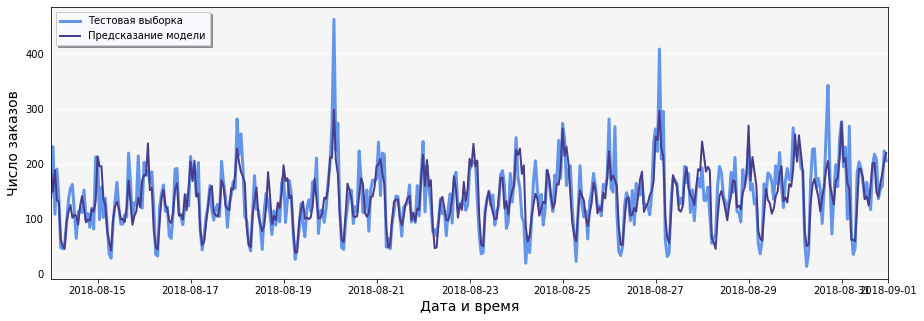

In [47]:
plot_line(
    [y_test, pd.Series(pred, index=y_test.index)], 'Дата и время', 'Число заказов',
    ['Тестовая выборка', 'Предсказание модели'], xlim=('2018-08-14', '2018-09-01'), lw=[3,2], colors=colors2
)

Визуально кажется, что линейная модель хорошо описывает как суточную, так и недельную сезонность. Проведём более детальный анализ.

###  Анализ остатков <a class="tocSkip">

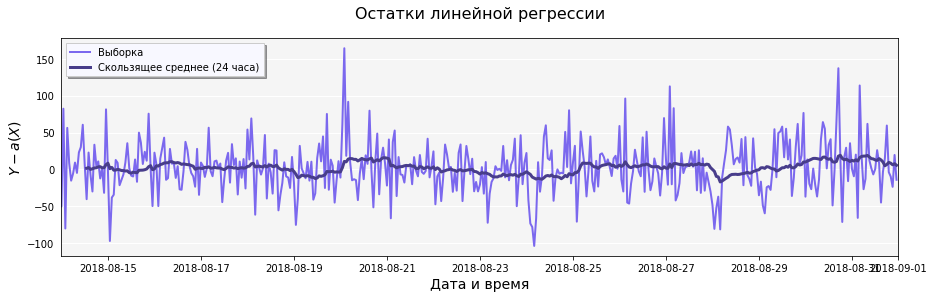

,Линейная регрессия
mean,2.266
50%,1.481
std,34.674


In [48]:
resid = y_test - pd.Series(pred, index=y_test.index)
plot_line(
    [resid, resid.rolling(24).mean()], 'Дата и время', '$Y - a(X)$', ['Выборка','Скользящее среднее (24 часа)'],
    title='Остатки линейной регрессии', xlim=('2018-08-14', '2018-09-01'), lw=[2,3], figsize=(15,4)
)
resid_info = resid.describe().to_frame().loc[['mean', '50%', 'std']]
resid_info.columns = ['Линейная регрессия']
resid_info

Видим, что модель в среднем немного занижает число заказов такси. Посмотрим на дисперсию.

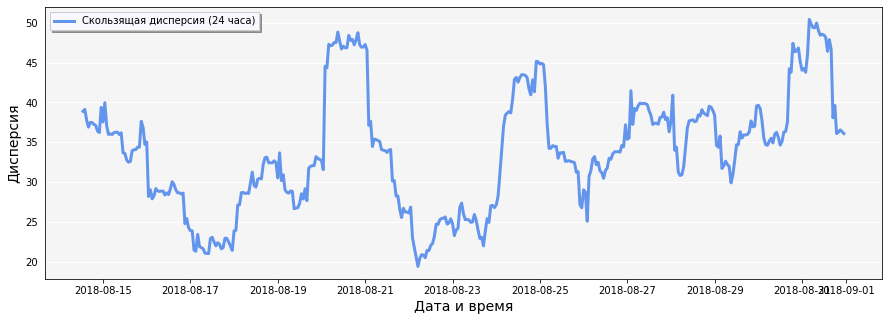

p-value: 6.9e-08


In [49]:
plot_line(
    [resid.rolling(24).std()], 'Дата и время', 
    'Дисперсия', ['Скользящая дисперсия (24 часа)'], colors=colors2, lw=[3]
)
test_hypothesis(resid, stat='adfuller')

Дисперсия со временем немного возрастает. Это особенно заметно на правой части графика. С другой стороны, гипотеза нестационарности уверенно отвергается. Сложно сказать, действительно ли остатки стационарны...

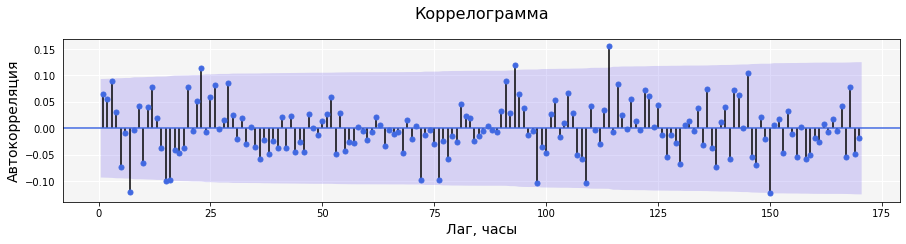

In [50]:
plot_autocorr(resid, 'часы', lags=170, figsize=(15,3))

Сезонность у остатков, похоже, отсутствует. Все автокорреляции небольшие и почти не выходят за границу статистической значимости.

Можно сделать вывод, что линейная модель хорошо описывает сезонность временного ряда, но плохо уловила общий тренд к увеличению разброса и среднего числа заказов, из-за чего остатки оказались смещёнными. Попробуем это исправить :)

## Линейная регрессия 2.0 
[к оглавлению](#start)

На этапе анализа данных мы обнаружили, что преобразование Бокса — Кокса позволяет стабилизировать дисперсию ряда.  
Обучим линейную регрессию на преобразованных данных и подберём гиперпараметры.

### Подбор гиперпараметров <a class="tocSkip">

``` python
data_ = data.copy()
data_['num_orders'], lmbd = st.boxcox(data_['num_orders'] + 1)
parameters_grid = {
    'transformer__poly__degree': [2], # от 1 до 3
    'scaler': [StandardScaler(), MinMaxScaler()],
    'model': [Lasso(random_state=42), Ridge(random_state=42)],
    'model__alpha': [10**i for i in np.arange(-3, 3, 1.)] # от 10^(-5) до 10^5
}
best_score = -1e10
prep_params = []
best_params = {}

for max_lag in [12]: # от 1 до 12
    for season_lags in [[24, 48, 72, 96, 168]]: # от 24 до 168 с шагом 24
        for window in [48]: # 12, 24, 36, 48
            
            x = AddFeatures(data_, max_lag, season_lags, window)
            x_train, y_train, _, _ = make_split(x)
            
            split_index = [0 if x in valid_index else -1 for x in x_train.index]
            pds = PredefinedSplit(test_fold = split_index) 
            
            transformer = ColumnTransformer(remainder='passthrough', transformers=[
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_columns),
                ('poly', poly, [col for col in x_train.columns if col not in cat_columns])
            ])
            pipeline.set_params(transformer=transformer)
            
            gs = GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_squared_error', cv=pds)
            gs.fit(x_train, y_train)
            
            if gs.best_score_ > best_score:
                best_score = gs.best_score_
                best_params = gs.best_params_
                prep_params = [max_lag, season_lags, window]
                
print('RMSE (отложенная выборка): {:.3f}'.format((-best_score)**0.5))
```

```
RMSE (отложенная выборка): 2.387
# RMSE такая низкая, т.к. считалась на преобразованных таргетах, а не на исходных
```

Оптимальные гиперпараметры практически не изменились. Коэффициент регуляризации уменьшился, а в выборку добавляется больше отстающих значений.

In [51]:
data_ = data.copy()
data_['num_orders'], lmbd = st.boxcox(data_['num_orders'] + 1)
x = AddFeatures(data_, 12, [24, 48, 72, 96, 168], 48)
x_train, y_train, x_test, y_test = make_split(x)

In [52]:
transformer = ColumnTransformer(remainder='passthrough', transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_columns),
    ('poly', poly, [col for col in x_train.columns if col not in cat_columns])
])
pipeline.set_params(
    transformer=transformer,
    transformer__poly__degree=3,
    scaler=MinMaxScaler(),
    model=Lasso(random_state=42, alpha=0.01),
)
pred = inv_boxcox(pipeline.fit(x_train, y_train).predict(x_test), lmbd)
y_test = inv_boxcox(y_test, lmbd)

In [53]:
scores.loc['Линейная регрессия 2.0'] = [
    mean_squared_error(y_test, pred)**0.5,
    mean_absolute_error(y_test, pred)**0.5,
    r2_score(y_test, pred),
    max_error(y_test, pred)
]
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709
Предыдущее значение ряда,58.856,6.706,-0.011,238.000
Линейная регрессия,34.709,5.083,0.649,164.265
Линейная регрессия 2.0,34.141,5.053,0.660,168.814


Качество немного улучшилось :)

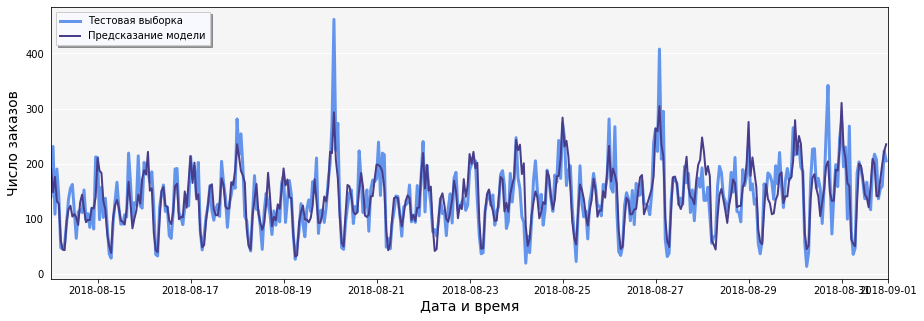

In [54]:
plot_line(
    [y_test, pd.Series(pred, index=y_test.index)], 'Дата и время', 'Число заказов',
    ['Тестовая выборка', 'Предсказание модели'], xlim=('2018-08-14', '2018-09-01'), lw=[3,2], colors=colors2)

Визуально отличий от предсказаний прошлой модели нет. Посмотрим на остатки.

###  Анализ остатков <a class="tocSkip">

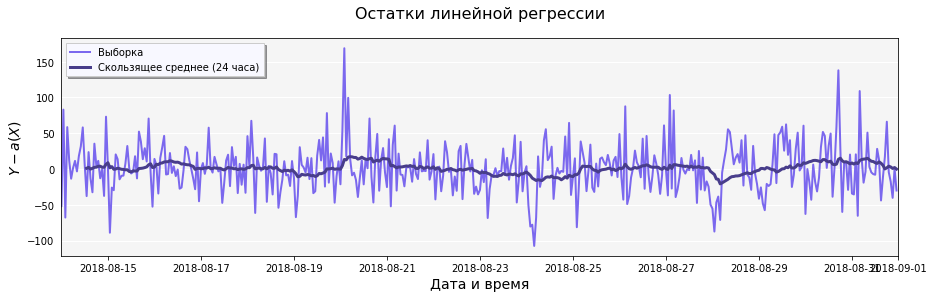

,Линейная регрессия,Линейная регрессия 2.0
mean,2.266,0.713
50%,1.481,-0.876
std,34.674,34.173


In [55]:
resid2 = y_test - pd.Series(pred, index=y_test.index)
plot_line(
    [resid2, resid2.rolling(24).mean()], 'Дата и время', '$Y - a(X)$', ['Выборка','Скользящее среднее (24 часа)'],
    title='Остатки линейной регрессии', xlim=('2018-08-14', '2018-09-01'), lw=[2,3], figsize=(15,4)
)
resid_info['Линейная регрессия 2.0'] = resid2.describe().loc[['mean', '50%', 'std']]
resid_info

Остатки в среднем ближе к нулю, а их дисперсия меньше. Следовательно, эта модель лучше описывает тренд ряда, чего мы и добивались :)

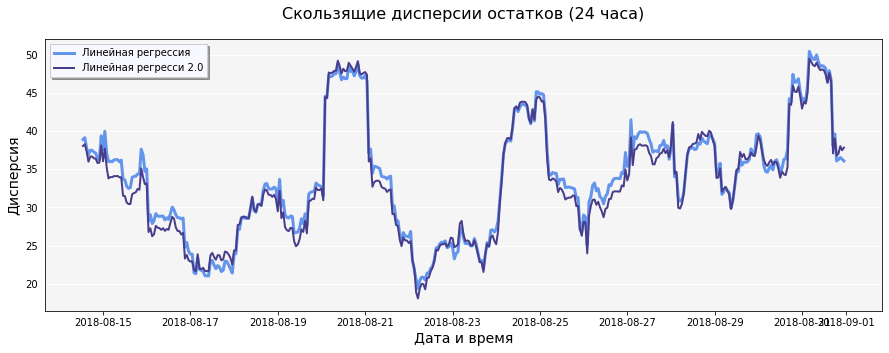

p-value: 7e-17


In [56]:
plot_line(
    [resid.rolling(24).std(), resid2.rolling(24).std()], 'Дата и время', 'Дисперсия', 
    ['Линейная регрессия','Линейная регресси 2.0'], 
    title='Скользящие дисперсии остатков (24 часа)', colors=colors2, lw=[3,2]
)
test_hypothesis(resid2, stat='adfuller')

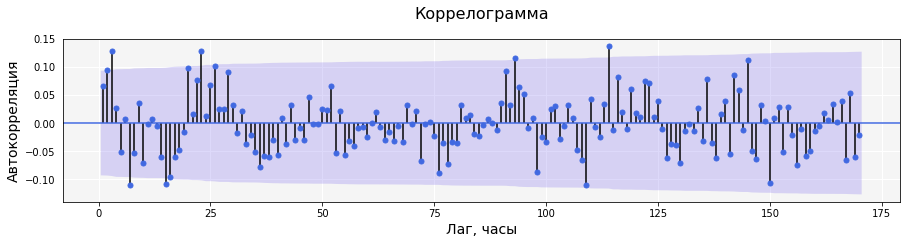

In [57]:
plot_autocorr(resid2, 'часы', lags=170, figsize=(15,3))

На этих двух графиках отличий от предыдущей модели не видно. Закон распределения остатков по-прежнему немного меняется со временем, сезонность отсутствует.

## Градиентный бустинг 
[к оглавлению](#start)

Теперь обучим более сложную модель — градиентный бустинг. Рассмотрим `LGBMRegressor()`. Предобработка здесь более простая: масштабирование и кодирование признаков не требуется.

Подберём оптимальные гиперпараметры модели:
* максимальная глубина базовых деревьев,
* шаг градиентного бустинга.

Параметры новых признаков (максимальный лаг и т.д.) варьируем точно так же.

### Подбор гиперпараметров <a class="tocSkip">

``` python
pipeline.set_params(
    transformer=None,
    scaler=None,
    model=LGBMRegressor(random_state=42, categorical_feature=[6,7,8], verbose=None, n_estimators=200)
)
parameters_grid = {
    'model__max_depth' : [5,6,7], # 5-16
    'model__learning_rate' : [0.1, 0.2] # 0.1-1.0
}
best_score = -1e10
prep_params = []
best_params = {}

for max_lag in [5,6,7]: # от 1 до 12
    for season_lags in [[i * 24 for i in range(1,8)]]: # от 24 до 168 с шагом 24
        for window in [36,48,60]: # 12, 24, 36, 48
            
            x = AddFeatures(data, max_lag, season_lags, window)
            x_train, y_train, _, _ = make_split(x)
            x_train[cat_columns] = x_train[cat_columns].astype('category')
            
            split_index = [0 if x in valid_index else -1 for x in x_train.index]
            pds = PredefinedSplit(test_fold = split_index) 

            gs = GridSearchCV(pipeline, parameters_grid, scoring='neg_mean_squared_error', cv=pds)
            gs.fit(x_train, y_train)
            
            if gs.best_score_ > best_score:
                best_score = gs.best_score_
                best_params = gs.best_params_
                prep_params = [max_lag, season_lags, window]
            print(max_lag, season_lags, window, '\n', (-best_score)**0.5)    
print('RMSE (отложенная выборка): {:.3f}'.format((-best_score)**0.5)) 
```

```
RMSE (отложенная выборка): 12.299
```

Оптимальным оказался бустинг над неглубокими деревьями (`max_depth=6`) с маленьким шагом (`learning_rate=0.1`).  
По сравнению с линейной моделью здесь в выборку добавляется больше признаков. 

Качество на отложенной выборке очень высокое. Оценим качество на тесте.

In [58]:
x = AddFeatures(data, 6, [i * 24 for i in range(1,8)], 48)
x_train, y_train, x_test, y_test = make_split(x)

In [59]:
pipeline.set_params(
    transformer=None,
    scaler=None,
    model=LGBMRegressor(random_state=42, categorical_feature=[6,7,8], verbose=None, n_estimators=200,
                       max_depth=6, learning_rate=0.1)
)
pred = pipeline.fit(x_train, y_train).predict(x_test)

In [60]:
scores.loc['Градиентный бустинг'] = [
    mean_squared_error(y_test, pred)**0.5,
    mean_absolute_error(y_test, pred)**0.5,
    r2_score(y_test, pred),
    max_error(y_test, pred)
]
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709
Предыдущее значение ряда,58.856,6.706,-0.011,238.000
Линейная регрессия,34.709,5.083,0.649,164.265
Линейная регрессия 2.0,34.141,5.053,0.660,168.814
Градиентный бустинг,38.623,5.257,0.565,233.412


Качество намного ниже, чем на отложенной выборке, что говорит о переобучении. Эта модель также хуже по сравнению с линейной регрессией.

Посмотрим на веса признаков.

In [61]:
feature_importances = pd.DataFrame(pipeline['model'].feature_importances_, columns=['importance'], 
                                        index=x_train.columns)
feature_importances.sort_values(by='importance', ascending=False)

,importance
day,274
lag_1,257
lag_96,243
lag_72,237
hour,224
lag_168,217
lag_120,177
lag_24,171
lag_2,164
lag_3,137


Наиболее значимый признак — день месяца. Это странно, ведь месячной сезонности у ряда мы не обнаружили. Вероятно, модель переобучена.

Построим график истинного и предсказанного числа заказов.

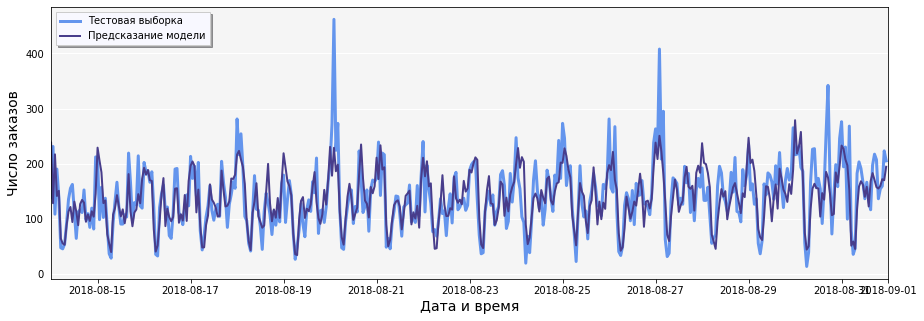

In [62]:
plot_line(
    [y_test, pd.Series(pred, index=y_test.index)], 'Дата и время', 'Число заказов',
    ['Тестовая выборка', 'Предсказание модели'], xlim=('2018-08-14', '2018-09-01'), lw=[3,2], colors=colors2
)

Сразу бросается в глаза, что модель плохо описывает недельную сезонность ряда: амплитуда суточных колебаний в среднем одинаковая в разные дни недели.

###  Анализ остатков <a class="tocSkip">

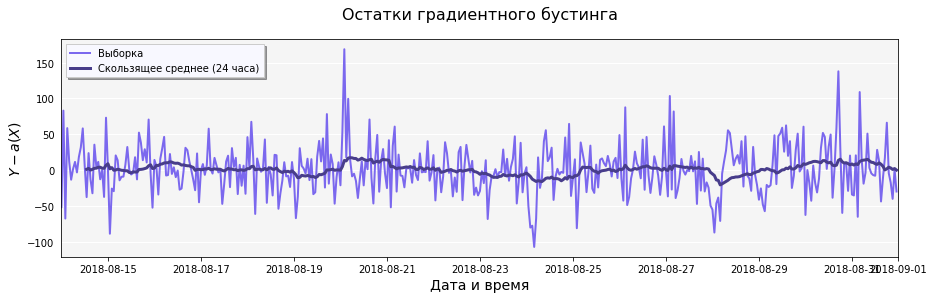

,Линейная регрессия,Линейная регрессия 2.0,Градиентный бустинг
mean,2.266,0.713,1.267
50%,1.481,-0.876,-1.730
std,34.674,34.173,38.646


In [63]:
resid = y_test - pd.Series(pred, index=y_test.index)
plot_line(
    [resid2, resid2.rolling(24).mean()], 'Дата и время', '$Y - a(X)$', ['Выборка','Скользящее среднее (24 часа)'],
    title='Остатки градиентного бустинга', xlim=('2018-08-14', '2018-09-01'), lw=[2,3], figsize=(15,4)
)
resid_info['Градиентный бустинг'] = resid.describe().loc[['mean', '50%', 'std']]
resid_info

Остатки градиентного бустинга смещённые, дисперсия выше, чем у линейных моделей.

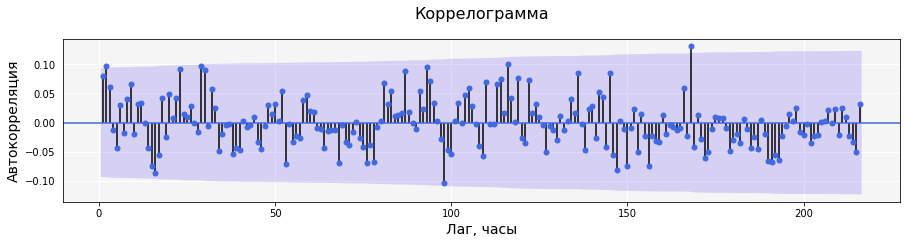

In [64]:
plot_autocorr(resid, 'часы', lags=24*9, figsize=(15,3))

Видим статистически значимую корреляцию при лаге 168 (1 неделя), что говорит о том, что у остатков есть сезонность.

## SARIMA 
[к оглавлению](#start)

Последняя модель, которую мы рассмотрим, — $SARIMA(p,d,q)\times(P,D,Q)$. 

### Подбор гиперпараметров <a class="tocSkip">

Сначала выберем начальные приближения для параметров $p-Q$. Анализ данных показал, что для того, чтобы привести ряд к стационарному, необходимо выполнить сезонное дифференцирование и затем обычное дифференцирование $\quad\to\quad d=1, D=1$.

Остальные параметры подберём по графикам частичной и полной автокорреляционной функций.

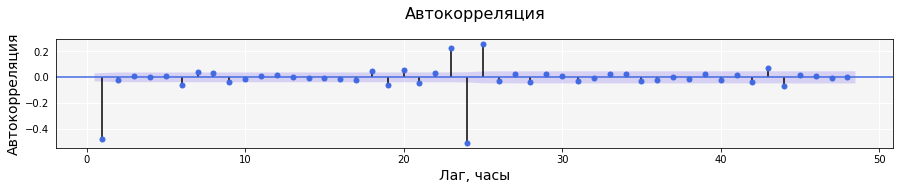

In [65]:
plot_autocorr(st_data['st_sigma_diff2'].dropna(), 'часы', lags=48, figsize=(15,2), title='Автокорреляция')

$Qs$ — это максимальный значимый сезонный лаг. В нашем случае период $s=24$, выберем $Q = 1$.  
Вообще говоря, значимая корреляция есть ещё при лаге в 1 неделю, однако параметр $Q = 7$ слишком усложнит модель.

$q$ — это максимальный значимый несезонный лаг. Выберем $q = 1$. Опять же, лаг 25 тоже значимый, но мы рассмотрим более простую модель.

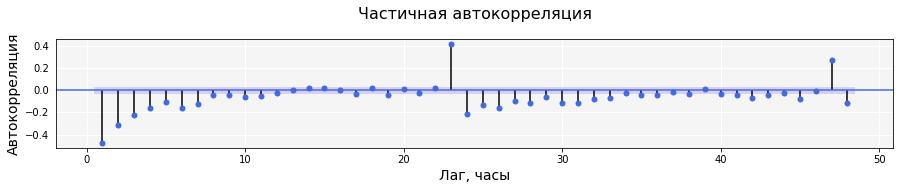

In [66]:
plot_autocorr(st_data['st_sigma_diff2'].dropna(), 'часы', lags=48, figsize=(15,2), 
              title='Частичная автокорреляция', kind='pacf')

$Ps$ — это максимальный значимый сезонный лаг на графике PACF. Выберем $P = 2$.

$p$ — это максимальный значимый несезонный лаг на графике PACF. Выберем $p = 6$. 

Теперь подберём оптимальные гиперпараметры модели. Будем варьировать значения $Q,q,P,p$ от нуля до начального приближения.

``` python
d = 1
D = 1
s = 24

p = [0, 1, 2, 3, 6] # 0 - 6
q = [0, 1] # 0 - 1
P = [0, 1] # 0 - 2
Q = [0, 1] # 0 - 1
parameters = list(product(p, q, P, Q))

train = data[:len(train_index) - len(valid_index)]
valid = data.loc[valid_index]

best_score = 1e10
parameters = [[3,1,1,1]]
for param in parameters:
    model = sm.tsa.statespace.SARIMAX(
        train,
        order=(param[0], d, param[1]),
        seasonal_order=(param[2], D, param[3], s)
    ).fit()
    pred = pd.Series(model.predict(start=len(train), end=len(train_index)-1), index=valid.index)
    rmse = mean_squared_error(valid, pred)**0.5
    if rmse < best_score:
        best_score = rmse
        best_params = param
        
print('RMSE (отложенная выборка): {:.3f}'.format(best_score))
```

```
RMSE (отложенная выборка): 30.911
```

Лучшее качество на отложенной выборке получилось при:
$$\cases{p=3\\q=1\\P=1\\Q=1}$$

Обучим модель с подобранными гиперпараметрами.

In [67]:
train = data.loc[train_index]
test = data.loc[test_index]

model = sm.tsa.statespace.SARIMAX(
        train,
        order=(3, 1, 1), # (p, d, q)
        seasonal_order=(1, 1, 1, 24) # (P, D, Q, s)
).fit()

pred = pd.Series(model.predict(start=len(train_index), end=len(train_index) + len(test_index)), index=test_index)

In [68]:
scores.loc['SARIMA'] = [
    mean_squared_error(test, pred)**0.5,
    mean_absolute_error(test, pred)**0.5,
    r2_score(test, pred),
    max_error(test, pred)
]
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709
Предыдущее значение ряда,58.856,6.706,-0.011,238.000
Линейная регрессия,34.709,5.083,0.649,164.265
Линейная регрессия 2.0,34.141,5.053,0.660,168.814
Градиентный бустинг,38.623,5.257,0.565,233.412
SARIMA,44.284,5.703,0.428,265.753


Качество модели ухудшилось, она ещё и обучается дольше остальных :(

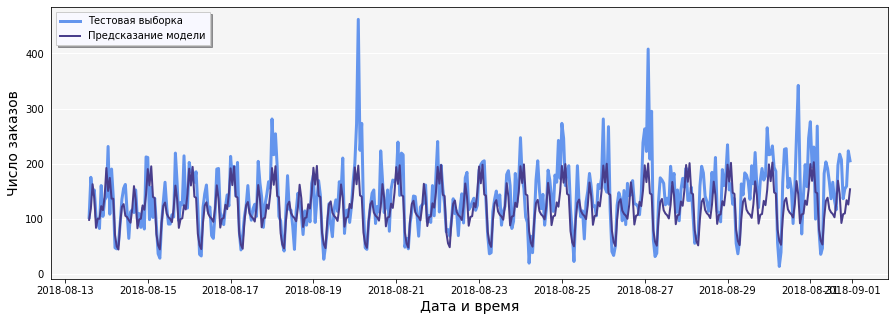

In [69]:
plot_line(
    [test, pred], 'Дата и время', 'Число заказов',
    ['Тестовая выборка', 'Предсказание модели'], lw=[3,2], colors=colors2)

C недельной сезонностью опять всё плохо. Возможно, увеличение значений параметров $P$ и $Q$ позволит предотвратить недообучение модели. Однако уже при небольших параметрах обучение занимает ощутимо больше времени по сравнению с линейной регрессией и бустингом, поэтому усложнять её мы не будем.

###  Анализ остатков <a class="tocSkip">

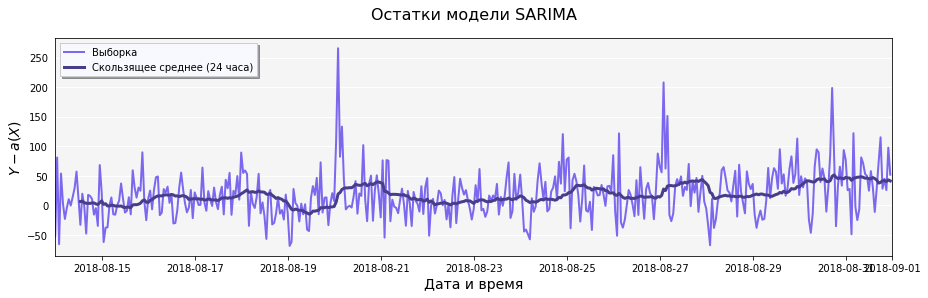

,Линейная регрессия,Линейная регрессия 2.0,Градиентный бустинг,SARIMA
mean,2.266,0.713,1.267,18.229
50%,1.481,-0.876,-1.730,15.735
std,34.674,34.173,38.646,40.404


In [70]:
resid = test['num_orders'] - pred
plot_line(
    [resid, resid.rolling(24).mean()], 'Дата и время', '$Y - a(X)$', ['Выборка','Скользящее среднее (24 часа)'],
    title='Остатки модели SARIMA', xlim=('2018-08-14', '2018-09-01'), lw=[2,3], figsize=(15,4)
)
resid_info['SARIMA'] = resid.describe().loc[['mean', '50%', 'std']]
resid_info

Снова сильная смещённость остатков.

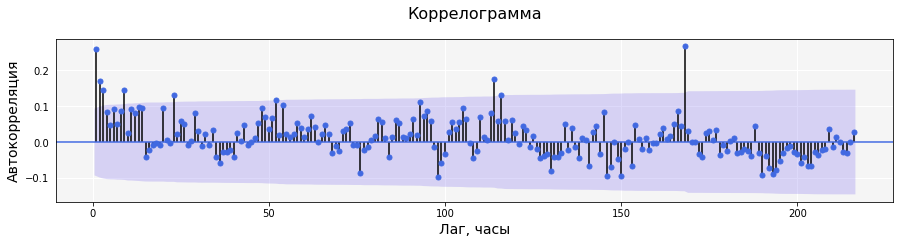

In [71]:
plot_autocorr(resid, 'часы', lags=24*9, figsize=(15,3))

Снова наблюдаем, что у остатков есть недельная сезонность.

#  Общий вывод 
[к оглавлению](#start)

Исследование заказов такси завершено.

1. Выполнена предобработка данных.
2. Проведён исследовательский анализ данных. Изучены характерные особенности временного ряда: выявлена сезонность и тренд. Проанализированы способы приведения ряда к стационарному. В выборку добавлены новые признаки, изучены взаимосвязи между ними и корреляция с таргетом.
3. Обучены четыре модели машинного обучения, с хорошей точностью предсказывающие число заказов такси в час. Модели адекватны: их качество лучше, чем у константной модели. Проанализированы сильные и слабые стороны моделей.

**Основные результаты**

1. Анализ данных показал, что временной ряд содержит четыре компоненты:
    * суточная сезонность
    * менее выраженная недельная сезонность
    * нелинейно возрастающий тренд
    * шум
    
Рассмотренные модели довольно хорошо описывают суточную сезонность, но с описанием недельной сезонности и особенно тренда возникают сложности.
    
2. Данные о качестве обученных моделей представлены в таблице:

In [72]:
scores

,RMSE,MAE,R2,max_error
Константная модель,84.744,68.354,-1.095,383.709
Предыдущее значение ряда,58.856,6.706,-0.011,238.000
Линейная регрессия,34.709,5.083,0.649,164.265
Линейная регрессия 2.0,34.141,5.053,0.660,168.814
Градиентный бустинг,38.623,5.257,0.565,233.412
SARIMA,44.284,5.703,0.428,265.753


Гиперпараметры моделей:

| Модель | Календарные признаки | Максимальный лаг (часы) | Сезонные лаги (сутки) | Размер окна (часы) | Другие признаки | Кодировка | Масштабирование | Другие параметры | 
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Линейная регрессия | + | 10 | 1 — 4, 7 | 36 | 2 порядка | OHE | MinMax | $\ell_1$-регуляризация, $\alpha=0.1$ |
| Линейная регрессия 2.0 | + | 12 | 1 — 4, 7 | 48 | 2 и 3 порядка | OHE | MinMax | преобразование Бокса — Кокса, $\ell_1$-регуляризация, $\alpha=0.01$ |
| Градиентный бустинг | + | 6 | 1 — 7 | 48 | — | auto | — | max_depth=6, learning_rate=0.1 |
| SARIMA | — | — | — | — | — | — | — | $(p, d, q) = (3, 1, 1)$, $(P, D, Q) = (1, 1, 1)$, $s=24$ |

* Наиболее точные предсказания даёт линейная регрессия. Обе модели линейной регрессии, рассмотренные в проекте, хорошо описывают характерные особенности ряда: суточную и недельную сезонность, а также нелинейно возрастающий тренд. Предварительная стабилизация дисперсии временного ряда при обучении второй модели улучшила качество.
* Градиентный бустинг показал очень хороший результат на валидации, но качество модели на тестовой выборке оказалось плохим, что говорит о плохой обобщающей способности модели.
* Модель SARIMA, наоборот, недообучена: она очень плохо описывает недельную сезонность и тренд временного ряда. Кроме того, обучение этой модели занимает больше времени по сравнению с остальными.

3. Также был проведён анализ остатков моделей:

| Модель | Среднее значение | Стандартное отклонение | p-value (критерий Дики — Фуллера) | Сезонность |
|:---:|:---:|:---:|:---:|:---:|
| Линейная регрессия | 2.3 | 34.7 | 7e-08 | — |
| Линейная регрессия 2.0 | 0.7 | 34.2 | 7e-17  | — |
| Градиентный бустинг | 1.3 | 38.6 | 9e-24 | T = 1 неделя |
| SARIMA | 18.3 | 40.4 | 4e-15 | T = 1 неделя |

* Остатки линейной регрессии получились немного смещёнными: обе модели в среднем занижают число заказов такси. Предварительная стабилизация дисперсии уменьшает смещённость остатков. Законы распределения остатков у обеих моделей не постоянны: их дисперсии увеличиваются со временем. При этом у остатков не наблюдается сезонности  
$\to$ линейная регрессия плохо описывает тренд временного ряда и хорошо описывает сезонность  
$\to$ стабилизация дисперсии временного ряда позволяет модели лучше уловить тренд
* Остаки градиентного бустинга и SARIMA также смещённые, дисперсии увеличиваются со временем. Кроме того, для них характерна недельная сезонность  
$\to$ эти модели плохо описывают тренд и недельную сезонность временного ряда и хорошо описывают суточную сезонность.

### Вывод <a class="tocSkip">

Таким образом, сравнение характеристик всех четырёх моделей показало, что лучшей моделью является линейная регрессия, обученная на данных со стабилизированной дисперсией.